# 1.Import Libraries

In [1]:
# Install Required Libraries
!pip install pandas numpy requests matplotlib seaborn tensorflow joblib

In [2]:
# Chunk #1: Import Essential Libraries

# Data manipulation and analysis
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations

# API and data collection
import requests  # For making HTTP requests to USGS API
from datetime import datetime, timedelta  # For handling dates and times
import json  # For parsing JSON responses

# Basic visualization
import matplotlib
import matplotlib.pyplot as plt  # For basic plotting
import seaborn as sns  # For statistical visualizations

# System utilities
import warnings  # For handling warning messages
warnings.filterwarnings('ignore')  # Suppress warning messages

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8-darkgrid')  # Using a valid style name
plt.rcParams['figure.figsize'] = (12, 8)

# Required Libraries for Chunk #6e-4. LSTM Model Implementation
from tensorflow.keras.layers import LayerNormalization, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint

# Print confirmation of successful library imports and versions
print("\nLibrary Import Confirmation:")
print("-" * 30)
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")
print("-" * 30)
print("Essential libraries successfully imported!")



Library Import Confirmation:
------------------------------
Pandas version: 2.2.2
NumPy version: 1.26.4
Matplotlib version: 3.8.0
Seaborn version: 0.13.2
------------------------------
Essential libraries successfully imported!


# 2.USGS API Data Collection

In [3]:
# Chunk #2: USGS API Data Collection

def fetch_earthquake_data(timeframe='week', min_magnitude=2.5):
    """
    Fetch earthquake data from USGS API

    Parameters:
    timeframe (str): 'hour', 'day', 'week', or 'month'
    min_magnitude (float): Minimum earthquake magnitude to include

    Returns:
    pandas DataFrame with earthquake data
    """
    # Define base URL for USGS GeoJSON feed
    base_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/"

    # Construct the endpoint URL based on parameters
    endpoint = f"{min_magnitude}_{timeframe}.geojson"
    url = base_url + endpoint

    try:
        # Make the API request
        print(f"Fetching data from {url}")
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes

        # Parse the JSON response
        data = response.json()

        # Extract the features from the GeoJSON
        earthquakes = data['features']

        # Create a list to store the processed data
        processed_data = []

        # Process each earthquake
        for quake in earthquakes:
            properties = quake['properties']
            coordinates = quake['geometry']['coordinates']

            # Extract relevant information
            processed_data.append({
                'time': datetime.fromtimestamp(properties['time'] / 1000),  # Convert milliseconds to datetime
                'magnitude': properties['mag'],
                'place': properties['place'],
                'longitude': coordinates[0],
                'latitude': coordinates[1],
                'depth': coordinates[2],
                'type': properties['type'],
                'alert': properties.get('alert', 'none'),  # Default to 'none' if no alert
                'tsunami': properties['tsunami'],
                'sig': properties['sig']  # Significance value
            })

        # Create DataFrame
        df = pd.DataFrame(processed_data)

        # Sort by time
        df = df.sort_values('time', ascending=False)

        # Print confirmation of successful data collection
        print("\nData Collection Summary:")
        print("-" * 30)
        print(f"Total earthquakes collected: {len(df)}")
        print(f"Date range: {df['time'].min()} to {df['time'].max()}")
        print(f"Magnitude range: {df['magnitude'].min():.1f} to {df['magnitude'].max():.1f}")
        print("-" * 30)

        return df

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None

# Test the function with a small sample
if __name__ == "__main__":
    # Fetch last week's earthquakes of magnitude 2.5 or greater
    df = fetch_earthquake_data(timeframe='week', min_magnitude=2.5)

    if df is not None:
        # Display the first few rows
        print("\nSample of collected data:")
        print("-" * 30)
        print(df.head())

        # Display data types and non-null counts
        print("\nDataset Information:")
        print("-" * 30)
        print(df.info())

Fetching data from https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson

Data Collection Summary:
------------------------------
Total earthquakes collected: 260
Date range: 2024-11-12 14:31:59.248000 to 2024-11-19 13:36:19.190000
Magnitude range: 2.5 to 6.6
------------------------------

Sample of collected data:
------------------------------
                     time  magnitude                               place  \
0 2024-11-19 13:36:19.190       2.52      2 km ESE of Yauco, Puerto Rico   
1 2024-11-19 12:56:02.383       2.50  55 km S of Whites City, New Mexico   
2 2024-11-19 12:23:22.989       4.60       Volcano Islands, Japan region   
3 2024-11-19 10:27:44.704       3.10        16 km NNE of Houston, Alaska   
4 2024-11-19 10:27:30.793       2.70     70 km NW of Lake Louise, Alaska   

   longitude   latitude     depth        type alert  tsunami  sig  
0   -66.8260  18.021833   10.8800  earthquake  None        0   98  
1  -104.4170  31.674000    6.3947  ea

# 3.Initial Data Analysis and Visualization

Fetching data from https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson

Data Collection Summary:
------------------------------
Total earthquakes collected: 260
Date range: 2024-11-12 14:31:59.248000 to 2024-11-19 13:36:19.190000
Magnitude range: 2.5 to 6.6
------------------------------

Initial Data Analysis:
------------------------------


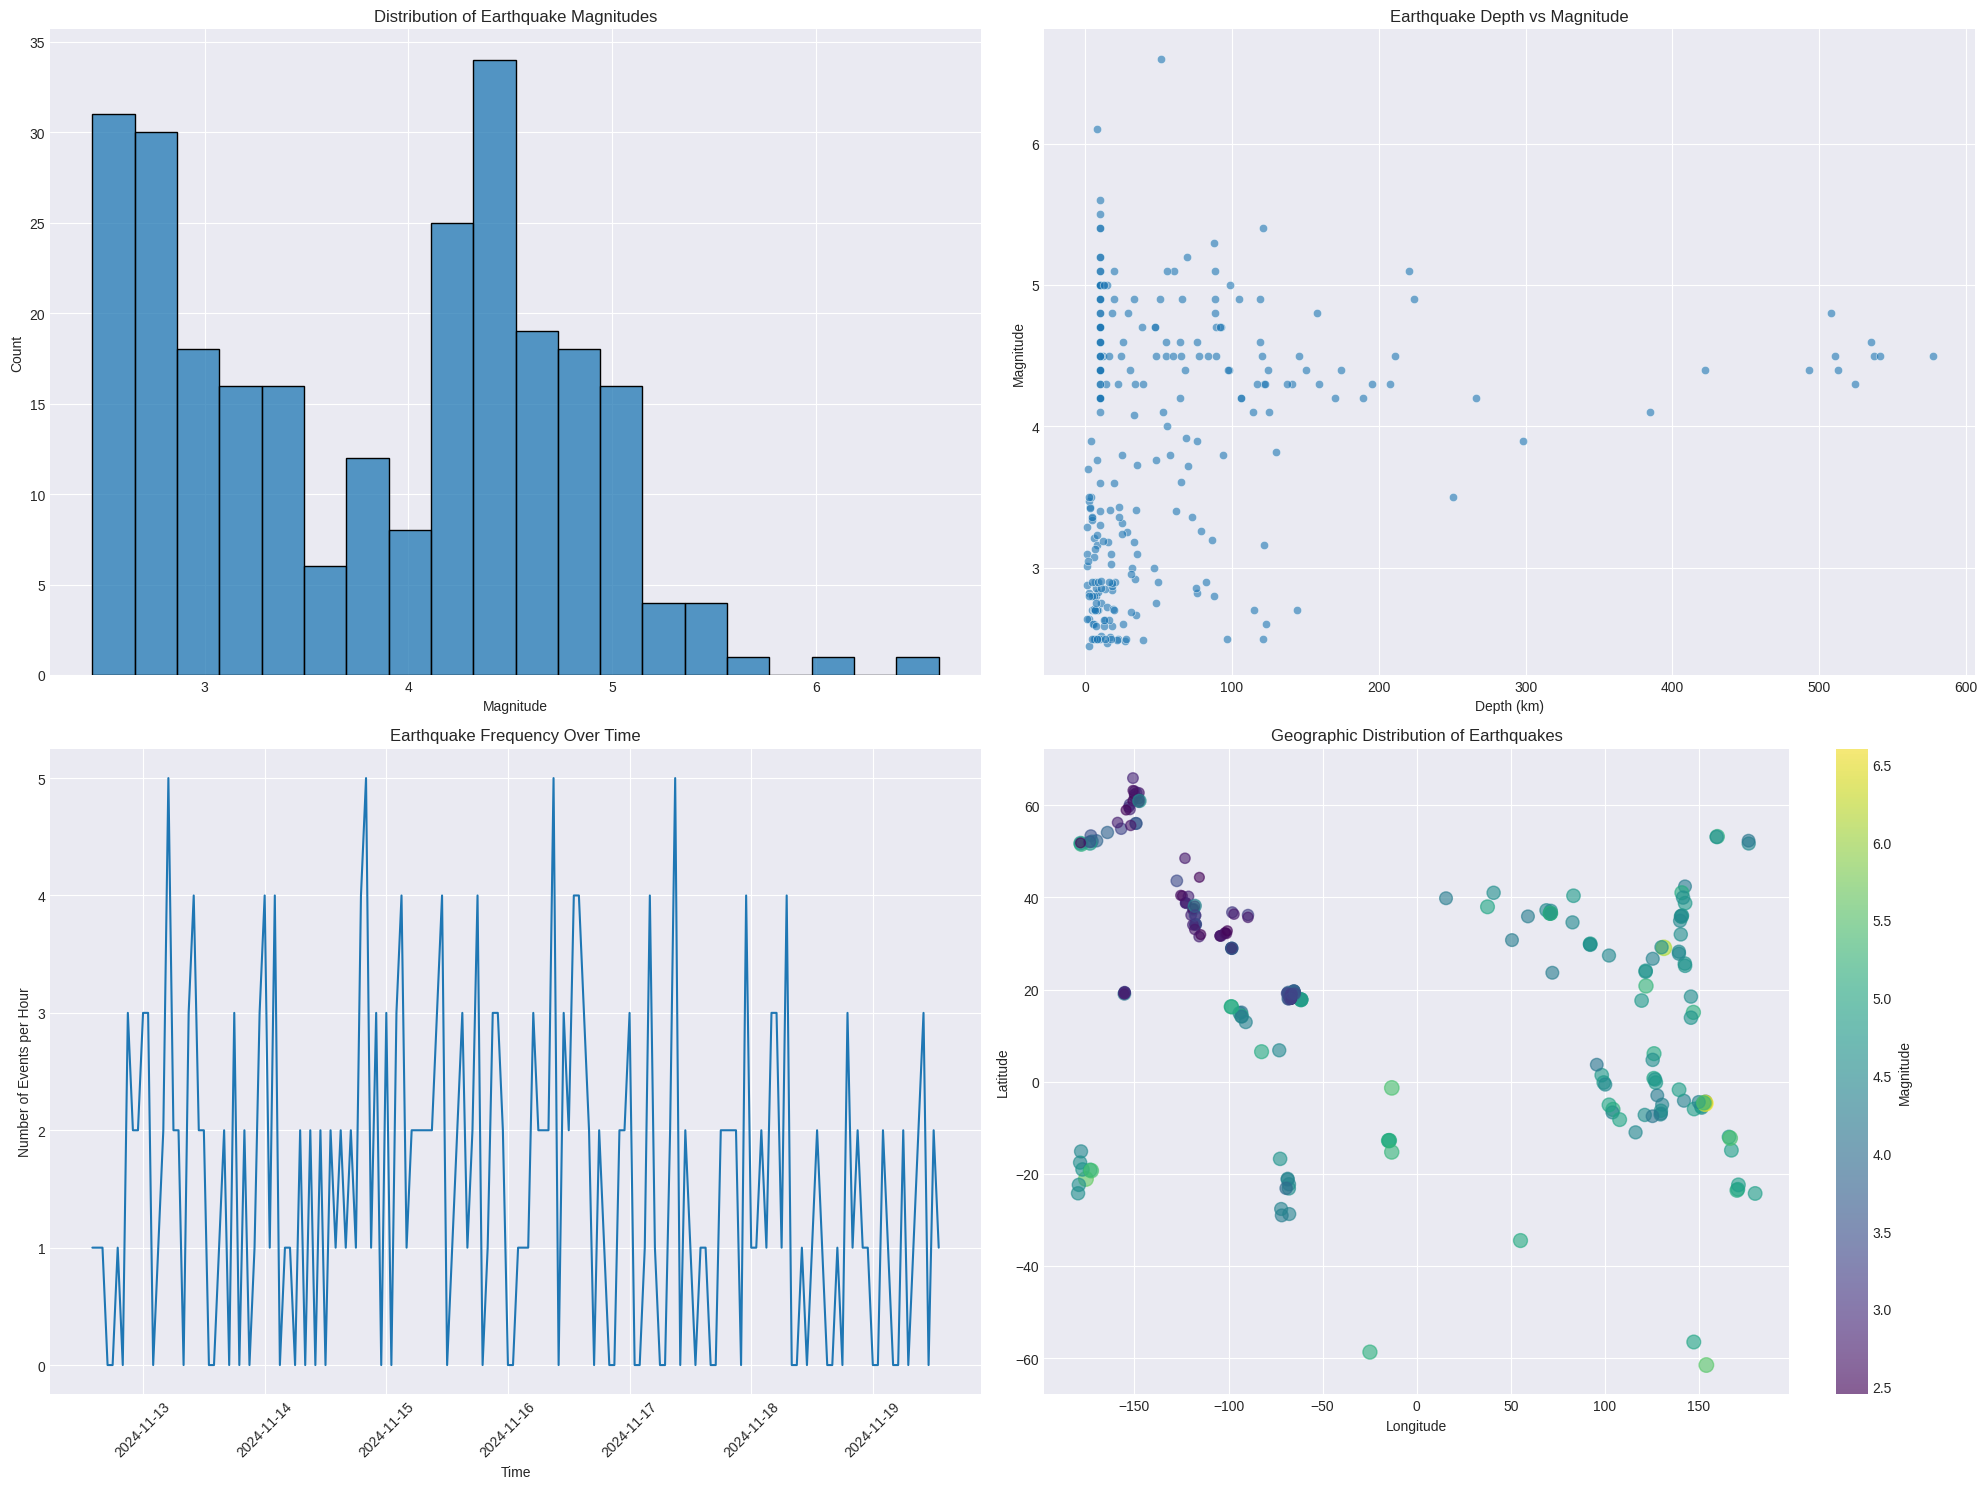


Statistical Summary:
------------------------------
        magnitude       depth         sig
count  260.000000  260.000000  260.000000
mean     3.823769   65.203274  240.969231
std      0.921110  107.384395  111.822110
min      2.450000    0.950000   93.000000
25%      2.900000   10.000000  129.000000
50%      3.960000   20.275500  259.000000
75%      4.500000   77.722750  326.000000
max      6.600000  577.324000  672.000000

Top 5 Regions by Event Count:
------------------------------
place
Puerto Rico    33
Alaska         32
Texas          18
Indonesia      17
CA             15
Name: count, dtype: int64

Hourly Distribution:
------------------------------
count    24.000000
mean     10.833333
std       3.157691
min       5.000000
25%       9.000000
50%      11.000000
75%      12.000000
max      19.000000
dtype: float64

Analysis Complete!
------------------------------
Total hours analyzed: 168
Average events per hour: 1.55
Peak events in one hour: 5


In [4]:
# Chunk #3: Initial Data Analysis and Visualization

def analyze_earthquake_patterns(df):
    """
    Analyze and visualize key patterns in earthquake data

    Parameters:
    df (pandas DataFrame): Earthquake data from fetch_earthquake_data()
    """
    print("\nInitial Data Analysis:")
    print("-" * 30)

    # Create figure with subplots
    plt.figure(figsize=(20, 15))

    # 1. Magnitude Distribution
    plt.subplot(2, 2, 1)
    sns.histplot(data=df, x='magnitude', bins=20)
    plt.title('Distribution of Earthquake Magnitudes')
    plt.xlabel('Magnitude')
    plt.ylabel('Count')

    # 2. Depth vs Magnitude Scatter
    plt.subplot(2, 2, 2)
    sns.scatterplot(data=df, x='depth', y='magnitude', alpha=0.6)
    plt.title('Earthquake Depth vs Magnitude')
    plt.xlabel('Depth (km)')
    plt.ylabel('Magnitude')

    # 3. Time Series of Events
    plt.subplot(2, 2, 3)
    df_hourly = df.set_index('time').resample('H').size()
    plt.plot(df_hourly.index, df_hourly.values)
    plt.title('Earthquake Frequency Over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Events per Hour')
    plt.xticks(rotation=45)

    # 4. Geographic Distribution
    plt.subplot(2, 2, 4)
    plt.scatter(df['longitude'], df['latitude'],
               c=df['magnitude'], cmap='viridis',
               s=df['magnitude']*20, alpha=0.6)
    plt.colorbar(label='Magnitude')
    plt.title('Geographic Distribution of Earthquakes')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.tight_layout()
    plt.show()

    # Statistical Summary
    print("\nStatistical Summary:")
    print("-" * 30)
    print(df[['magnitude', 'depth', 'sig']].describe())

    # Region Analysis
    print("\nTop 5 Regions by Event Count:")
    print("-" * 30)
    region_counts = df['place'].str.split(', ').str[-1].value_counts().head()
    print(region_counts)

    # Time Patterns
    df['hour'] = df['time'].dt.hour
    print("\nHourly Distribution:")
    print("-" * 30)
    print(df.groupby('hour').size().describe())

    return df_hourly  # Return hourly frequency for potential future analysis

# Test the analysis function
if __name__ == "__main__":
    # Fetch the data using the function from Chunk #2
    df = fetch_earthquake_data(timeframe='week', min_magnitude=2.5)

    if df is not None:
        # Perform analysis
        hourly_data = analyze_earthquake_patterns(df)

        # Print confirmation of analysis completion
        print("\nAnalysis Complete!")
        print("-" * 30)
        print(f"Total hours analyzed: {len(hourly_data)}")
        print(f"Average events per hour: {hourly_data.mean():.2f}")
        print(f"Peak events in one hour: {hourly_data.max()}")

# 4.Regional Analysis

Fetching data from https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson

Data Collection Summary:
------------------------------
Total earthquakes collected: 260
Date range: 2024-11-12 14:31:59.248000 to 2024-11-19 13:36:19.190000
Magnitude range: 2.5 to 6.6
------------------------------

Regional Analysis Results:
------------------------------
Total regions: 57
Regions with 5+ events: 14


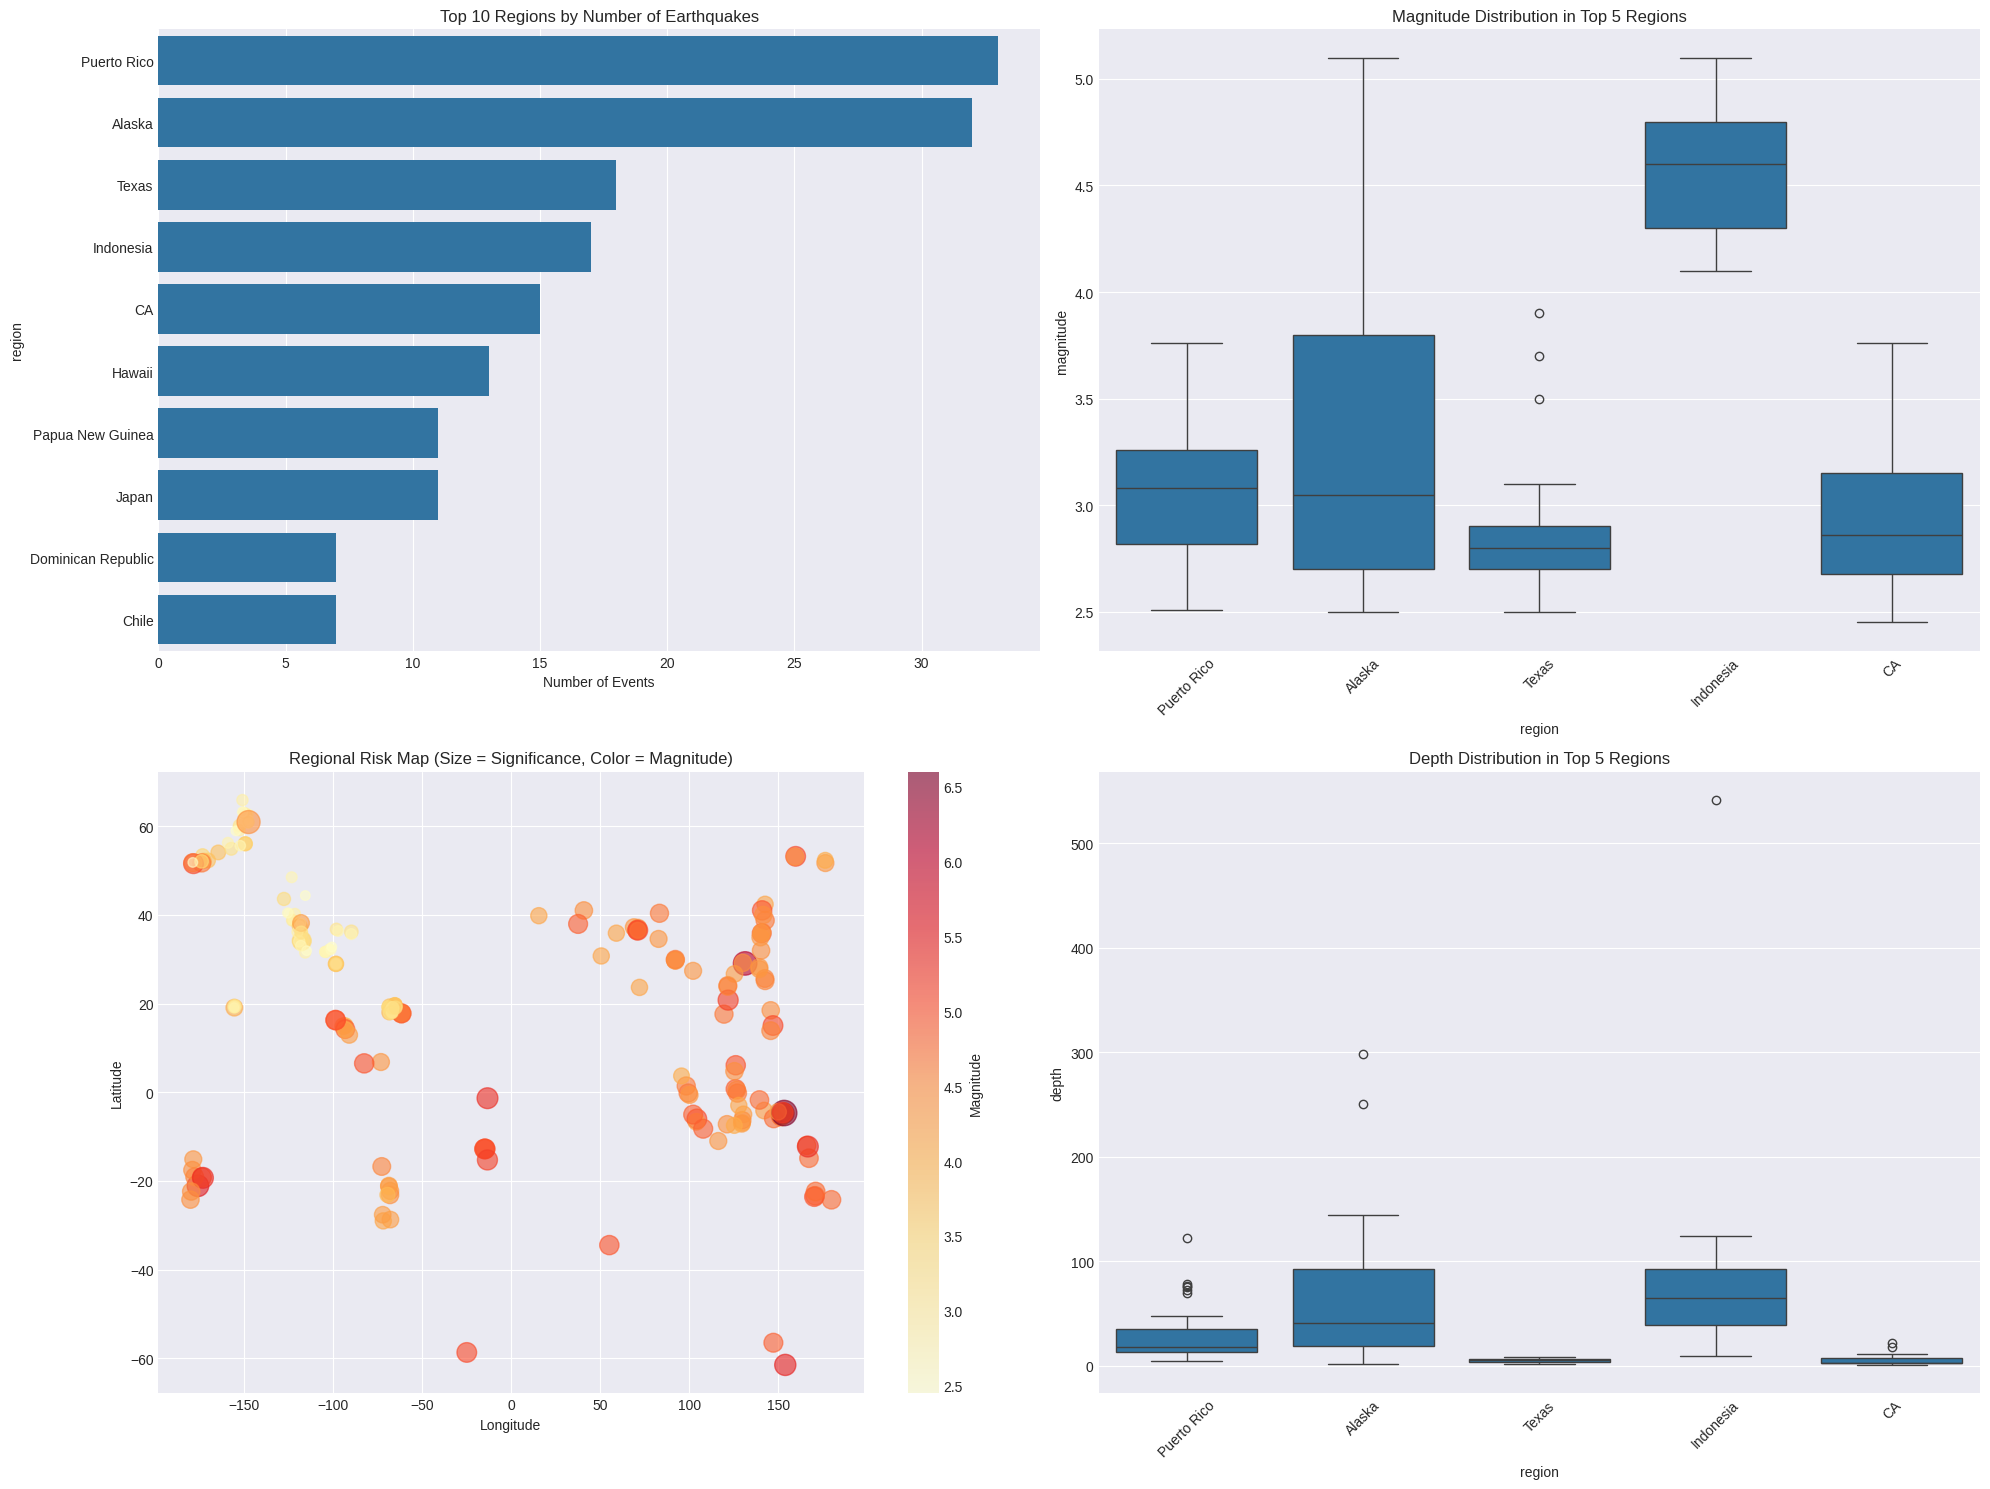


Top 10 Regions by Risk Score:
------------------------------
region
Tonga                          3.47
Papua New Guinea               3.46
Balleny Islands region         3.43
Indonesia                      3.40
southern Mid-Atlantic Ridge    3.40
north of Ascension Island      3.36
Japan                          3.36
Philippines                    3.22
Solomon Islands                3.20
Mexico                         3.13
dtype: float64

Regional Analysis Complete!
------------------------------
Regions analyzed: 57
Maximum risk score: 3.47
Average risk score: 2.70


In [5]:
# Chunk #4: Regional Analysis

def analyze_regions(df):
    """
    Perform detailed regional analysis of earthquake data

    Parameters:
    df (pandas DataFrame): Earthquake data from fetch_earthquake_data()
    """
    # Create region column by extracting the last part of the place string
    df['region'] = df['place'].str.split(', ').str[-1]

    # Calculate regional metrics
    regional_stats = df.groupby('region').agg({
        'magnitude': ['count', 'mean', 'max', 'std'],
        'depth': 'mean',
        'sig': 'mean'
    }).round(2)

    # Sort by event count
    regional_stats = regional_stats.sort_values(('magnitude', 'count'), ascending=False)

    # Only analyze regions with at least 5 events for statistical significance
    significant_regions = regional_stats[regional_stats[('magnitude', 'count')] >= 5]

    print("\nRegional Analysis Results:")
    print("-" * 30)
    print(f"Total regions: {len(regional_stats)}")
    print(f"Regions with 5+ events: {len(significant_regions)}")

    # Create visualizations
    plt.figure(figsize=(20, 15))

    # 1. Top Regions by Event Count
    plt.subplot(2, 2, 1)
    top_regions = regional_stats[('magnitude', 'count')][:10]
    sns.barplot(x=top_regions.values, y=top_regions.index)
    plt.title('Top 10 Regions by Number of Earthquakes')
    plt.xlabel('Number of Events')

    # 2. Regional Magnitude Distribution
    plt.subplot(2, 2, 2)
    top_5_regions = regional_stats.index[:5]
    region_mag_data = df[df['region'].isin(top_5_regions)]
    sns.boxplot(data=region_mag_data, x='region', y='magnitude')
    plt.title('Magnitude Distribution in Top 5 Regions')
    plt.xticks(rotation=45)

    # 3. Regional Risk Map
    plt.subplot(2, 2, 3)
    scatter = plt.scatter(df['longitude'], df['latitude'],
                         c=df['magnitude'], cmap='YlOrRd',
                         s=df['sig']/2, alpha=0.6)
    plt.colorbar(scatter, label='Magnitude')
    plt.title('Regional Risk Map (Size = Significance, Color = Magnitude)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # 4. Depth Distribution by Region
    plt.subplot(2, 2, 4)
    sns.boxplot(data=region_mag_data, x='region', y='depth')
    plt.title('Depth Distribution in Top 5 Regions')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Calculate risk scores for each region
    risk_scores = df.groupby('region').apply(lambda x: calculate_risk_score(x))
    risk_scores = risk_scores.sort_values(ascending=False)

    print("\nTop 10 Regions by Risk Score:")
    print("-" * 30)
    print(risk_scores.head(10))

    return regional_stats, risk_scores

def calculate_risk_score(group):
    """
    Calculate a risk score for a region based on multiple factors

    Parameters:
    group (pandas DataFrame): Group of earthquakes for a region

    Returns:
    float: Risk score
    """
    # Weights for different factors
    magnitude_weight = 0.4
    frequency_weight = 0.3
    significance_weight = 0.2
    depth_weight = 0.1

    # Calculate components
    avg_magnitude = group['magnitude'].mean()
    event_count = len(group)
    avg_significance = group['sig'].mean()
    avg_depth = group['depth'].mean()

    # Normalize depth (shallower earthquakes are more dangerous)
    depth_factor = 1 / (1 + avg_depth/100)

    # Calculate final score
    risk_score = (
        magnitude_weight * avg_magnitude +
        frequency_weight * np.log1p(event_count) +
        significance_weight * (avg_significance/100) +
        depth_weight * depth_factor
    )

    return round(risk_score, 2)

# Test the regional analysis
if __name__ == "__main__":
    # Fetch the data using the function from Chunk #2
    df = fetch_earthquake_data(timeframe='week', min_magnitude=2.5)

    if df is not None:
        # Perform regional analysis
        regional_stats, risk_scores = analyze_regions(df)

        # Print confirmation of analysis completion
        print("\nRegional Analysis Complete!")
        print("-" * 30)
        print(f"Regions analyzed: {len(risk_scores)}")
        print(f"Maximum risk score: {risk_scores.max():.2f}")
        print(f"Average risk score: {risk_scores.mean():.2f}")

# 5.Temporal Pattern Analysis

Fetching data from https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson

Data Collection Summary:
------------------------------
Total earthquakes collected: 260
Date range: 2024-11-12 14:31:59.248000 to 2024-11-19 13:36:19.190000
Magnitude range: 2.5 to 6.6
------------------------------


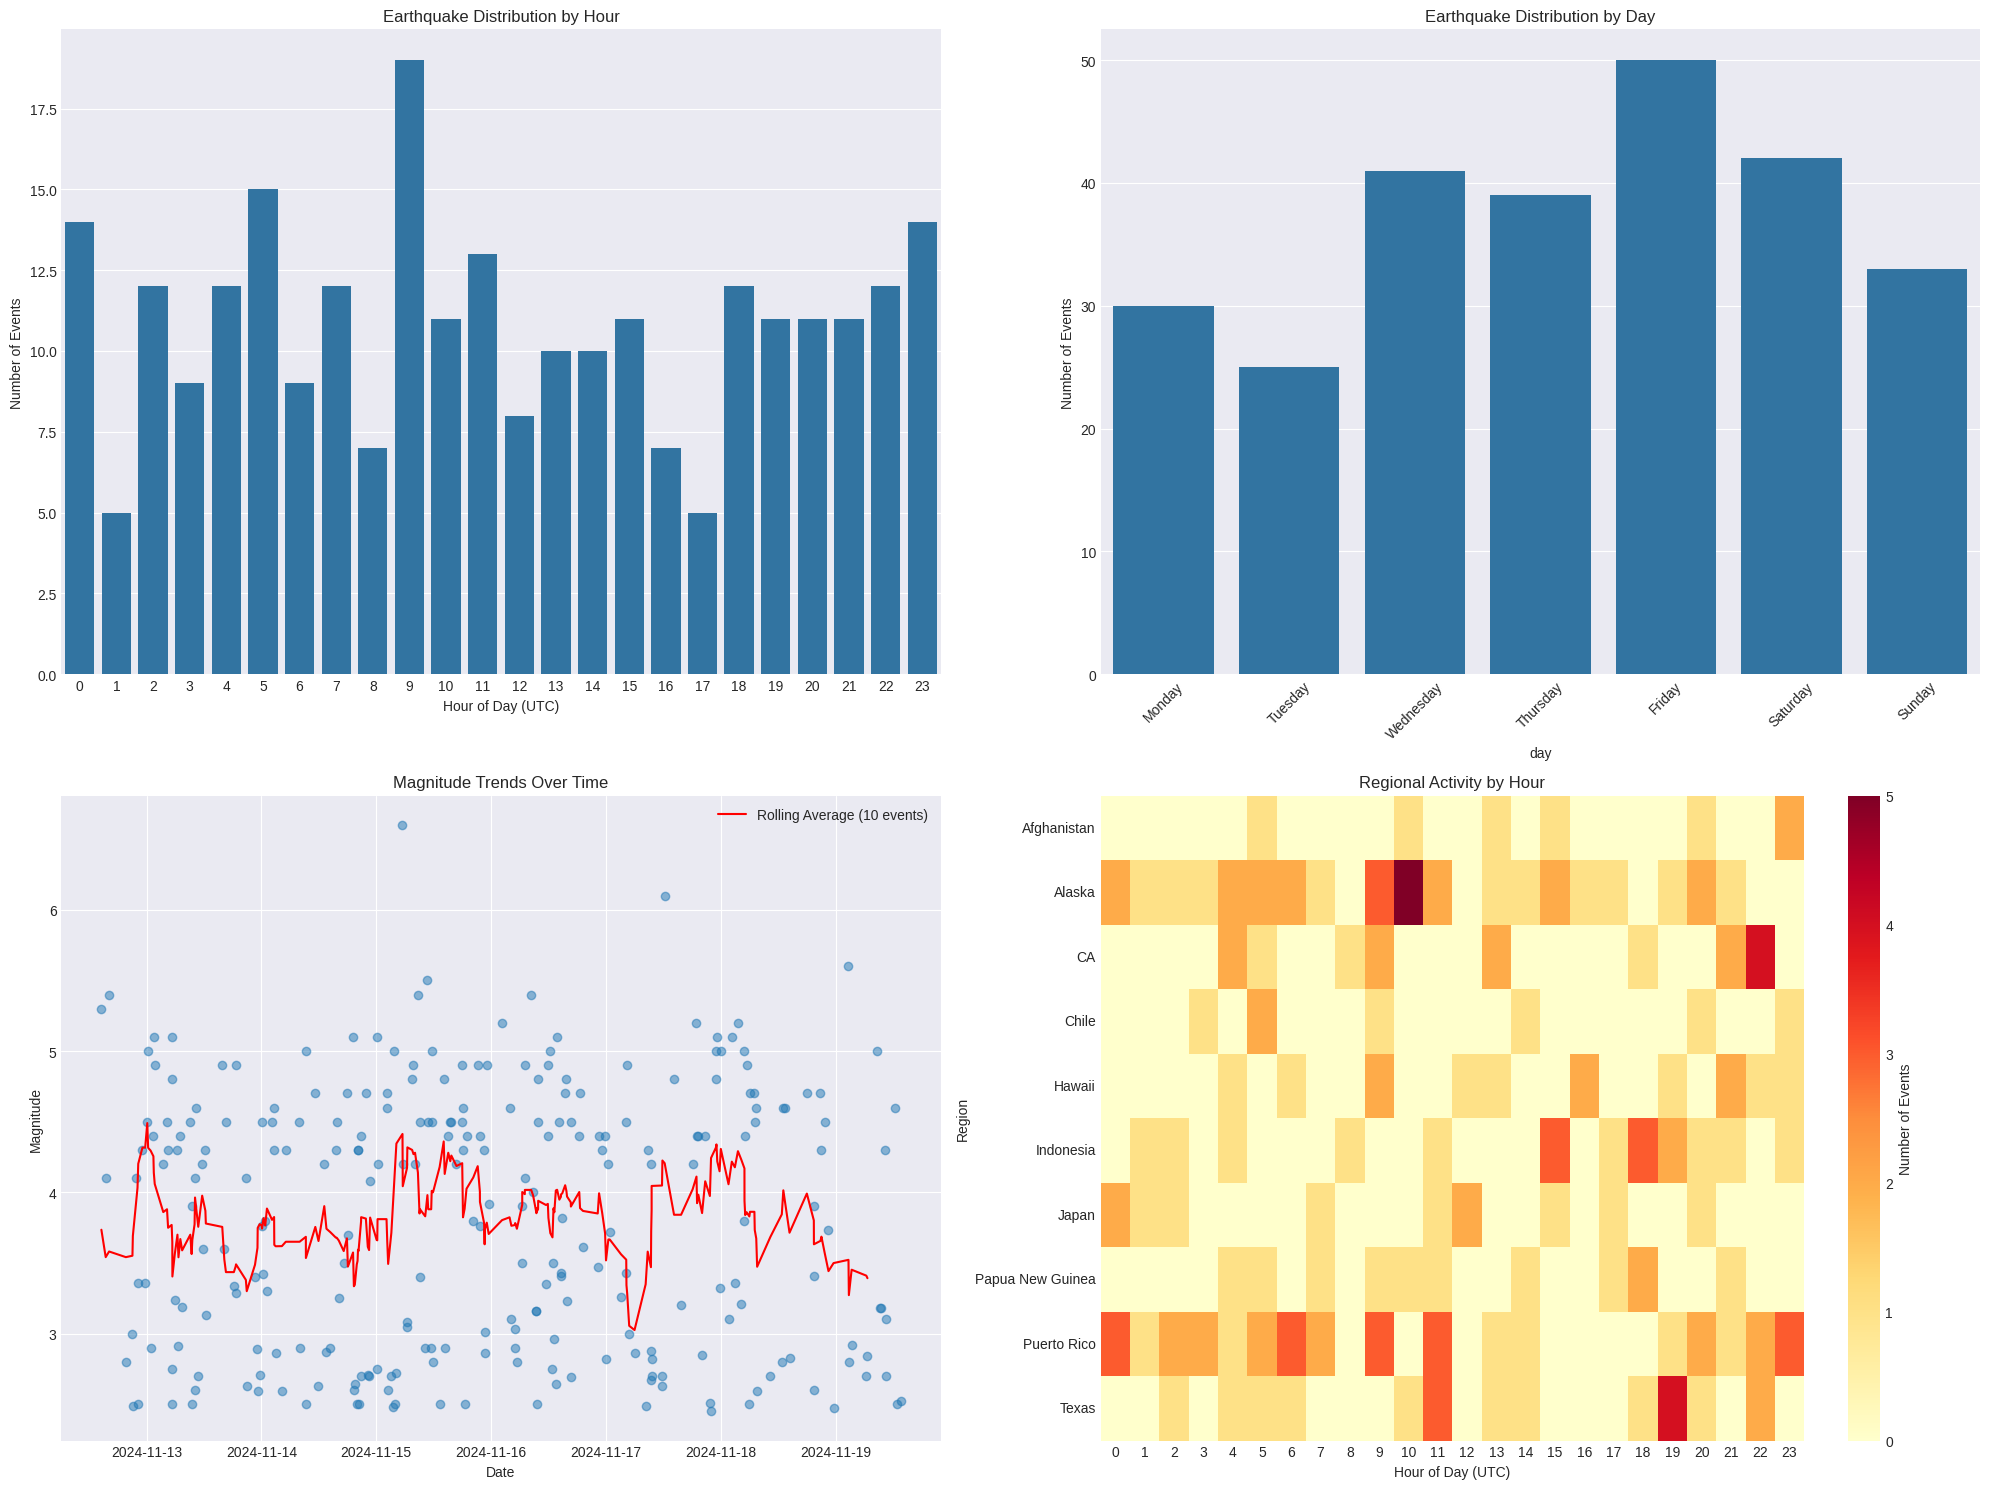


Temporal Analysis Results:
------------------------------

Peak Activity Hours (UTC):
------------------------------
hour
9    19
5    15
0    14
Name: count, dtype: int64

Daily Activity Summary:
------------------------------
          magnitude             depth
              count  mean  max   mean
day                                  
Friday           50  4.01  6.6  51.57
Monday           30  3.95  5.2  35.64
Saturday         42  3.92  5.4  96.68
Sunday           33  3.72  6.1  79.41
Thursday         39  3.67  5.1  72.22
Tuesday          25  3.55  5.6  51.30
Wednesday        41  3.80  5.1  61.57

Activity Rate Changes:
------------------------------
Maximum daily increase: 272.7%
Maximum daily decrease: -53.3%
Average daily change: 28.0%

Temporal Analysis Complete!
------------------------------
Hours analyzed: 24
Days analyzed: 7
Regions in hourly analysis: 10


In [6]:
# Chunk #5: Temporal Pattern Analysis

def analyze_temporal_patterns(df):
    """
    Analyze temporal patterns in earthquake data

    Parameters:
    df (pandas DataFrame): Earthquake data from fetch_earthquake_data()

    Returns:
    tuple: (hourly_stats, daily_stats, region_time_data)
    """
    # Extract region from place column
    df['region'] = df['place'].str.split(', ').str[-1]

    # Add time components
    df['hour'] = df['time'].dt.hour
    df['day'] = df['time'].dt.day_name()
    df['date'] = df['time'].dt.date

    # Create figure for temporal analysis
    plt.figure(figsize=(20, 15))

    # 1. Hourly Event Distribution
    plt.subplot(2, 2, 1)
    hourly_counts = df.groupby('hour').size()
    sns.barplot(x=hourly_counts.index, y=hourly_counts.values)
    plt.title('Earthquake Distribution by Hour')
    plt.xlabel('Hour of Day (UTC)')
    plt.ylabel('Number of Events')

    # 2. Daily Pattern Analysis
    plt.subplot(2, 2, 2)
    daily_counts = df.groupby('day').size()
    # Reorder days of week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_counts = daily_counts.reindex(day_order)
    sns.barplot(x=daily_counts.index, y=daily_counts.values)
    plt.title('Earthquake Distribution by Day')
    plt.xticks(rotation=45)
    plt.ylabel('Number of Events')

    # 3. Magnitude Time Series
    plt.subplot(2, 2, 3)
    plt.scatter(df['time'], df['magnitude'], alpha=0.5)
    plt.plot(df['time'], df['magnitude'].rolling(window=10).mean(), color='red',
             label='Rolling Average (10 events)')
    plt.title('Magnitude Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Magnitude')
    plt.legend()

    # 4. Regional Activity Heatmap
    plt.subplot(2, 2, 4)
    # Get top 10 regions by event count
    top_regions = df['region'].value_counts().head(10).index
    region_time_data = df[df['region'].isin(top_regions)].copy()

    # Create hourly event counts for each region
    pivot_table = pd.crosstab(region_time_data['region'], region_time_data['hour'])
    sns.heatmap(pivot_table, cmap='YlOrRd', cbar_kws={'label': 'Number of Events'})
    plt.title('Regional Activity by Hour')
    plt.xlabel('Hour of Day (UTC)')
    plt.ylabel('Region')

    plt.tight_layout()
    plt.show()

    # Statistical Analysis
    print("\nTemporal Analysis Results:")
    print("-" * 30)

    # Hourly Statistics
    hourly_stats = df.groupby('hour').agg({
        'magnitude': ['count', 'mean', 'max'],
        'depth': 'mean'
    }).round(2)

    print("\nPeak Activity Hours (UTC):")
    print("-" * 30)
    peak_hours = hourly_stats['magnitude']['count'].nlargest(3)
    print(peak_hours)

    # Daily Statistics
    daily_stats = df.groupby('day').agg({
        'magnitude': ['count', 'mean', 'max'],
        'depth': 'mean'
    }).round(2)

    print("\nDaily Activity Summary:")
    print("-" * 30)
    print(daily_stats)

    # Calculate activity rate changes
    events_per_day = df.groupby('date').size()
    daily_change = events_per_day.pct_change() * 100

    print("\nActivity Rate Changes:")
    print("-" * 30)
    print(f"Maximum daily increase: {daily_change.max():.1f}%")
    print(f"Maximum daily decrease: {daily_change.min():.1f}%")
    print(f"Average daily change: {daily_change.mean():.1f}%")

    return hourly_stats, daily_stats, region_time_data

# Test the temporal analysis
if __name__ == "__main__":
    # Fetch the data using the function from Chunk #2
    df = fetch_earthquake_data(timeframe='week', min_magnitude=2.5)

    if df is not None:
        # Perform temporal analysis
        hourly_stats, daily_stats, region_time_data = analyze_temporal_patterns(df)

        # Print confirmation of analysis completion
        print("\nTemporal Analysis Complete!")
        print("-" * 30)
        print(f"Hours analyzed: 24")
        print(f"Days analyzed: 7")
        print(f"Regions in hourly analysis: {len(region_time_data['region'].unique())}")

# 6.Import ML Libraries and Data Preparation

In [7]:
# Chunk #6: Predictive Modeling - Import Libraries and Data Preparation

# Import additional ML libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib

def prepare_data_for_modeling(df):
    """
    Prepare earthquake data for modeling by creating features and handling missing values

    Parameters:
    df (pandas DataFrame): Earthquake data from fetch_earthquake_data()

    Returns:
    tuple: (processed_df, feature_sets)
    """
    print("\nPreparing Data for Modeling:")
    print("-" * 30)

    # Create a copy of the dataframe to avoid modifications to original
    processed_df = df.copy()

    # Extract region from place
    processed_df['region'] = processed_df['place'].str.split(', ').str[-1]

    # Create time-based features
    processed_df['hour'] = processed_df['time'].dt.hour
    processed_df['day_of_week'] = processed_df['time'].dt.dayofweek

    # Create risk categories based on magnitude and significance
    processed_df['risk_category'] = pd.qcut(
        processed_df['magnitude'] * processed_df['sig'],
        q=3,
        labels=['Low', 'Medium', 'High']
    )

    # Define feature sets for different models
    feature_sets = {
        'pca_features': ['magnitude', 'depth', 'sig', 'latitude', 'longitude'],
        'regression_features': ['depth', 'latitude', 'longitude', 'hour', 'day_of_week'],
        'sequence_features': ['magnitude', 'depth', 'sig']
    }

    # Handle missing values
    for feature_list in feature_sets.values():
        for feature in feature_list:
            if feature in processed_df.columns:
                processed_df[feature].fillna(processed_df[feature].mean(), inplace=True)

    # Print data preparation summary
    print("Data Preparation Summary:")
    print(f"Total samples: {len(processed_df)}")
    print(f"Features created: hour, day_of_week, risk_category")
    print(f"Missing values handled for {len(set().union(*feature_sets.values()))} features")

    return processed_df, feature_sets

# Test the data preparation
if __name__ == "__main__":
    # Fetch the data using the function from Chunk #2
    df = fetch_earthquake_data(timeframe='week', min_magnitude=2.5)

    if df is not None:
        # Prepare data
        processed_df, feature_sets = prepare_data_for_modeling(df)

        # Print confirmation
        print("\nData Preparation Complete!")
        print("-" * 30)
        print("Processed DataFrame Info:")
        print(processed_df.info())

        # Display sample of processed data
        print("\nSample of Processed Data:")
        print(processed_df[['magnitude', 'depth', 'risk_category', 'hour', 'day_of_week']].head())

Fetching data from https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson

Data Collection Summary:
------------------------------
Total earthquakes collected: 260
Date range: 2024-11-12 14:31:59.248000 to 2024-11-19 13:36:19.190000
Magnitude range: 2.5 to 6.6
------------------------------

Preparing Data for Modeling:
------------------------------
Data Preparation Summary:
Total samples: 260
Features created: hour, day_of_week, risk_category
Missing values handled for 7 features

Data Preparation Complete!
------------------------------
Processed DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   time           260 non-null    datetime64[ns]
 1   magnitude      260 non-null    float64       
 2   place          260 non-null    object        
 3   longitude      260 non-null    float64     

## 6b. Dimensionality Reduction

Fetching data from https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson

Data Collection Summary:
------------------------------
Total earthquakes collected: 260
Date range: 2024-11-12 14:31:59.248000 to 2024-11-19 13:36:19.190000
Magnitude range: 2.5 to 6.6
------------------------------

Preparing Data for Modeling:
------------------------------
Data Preparation Summary:
Total samples: 260
Features created: hour, day_of_week, risk_category
Missing values handled for 7 features

Performing Dimensionality Reduction:
------------------------------
PCA Results:
Component 1: 0.5847 explained variance
Component 2: 0.1875 explained variance
Component 3: 0.1306 explained variance
Cumulative explained variance: 0.9027


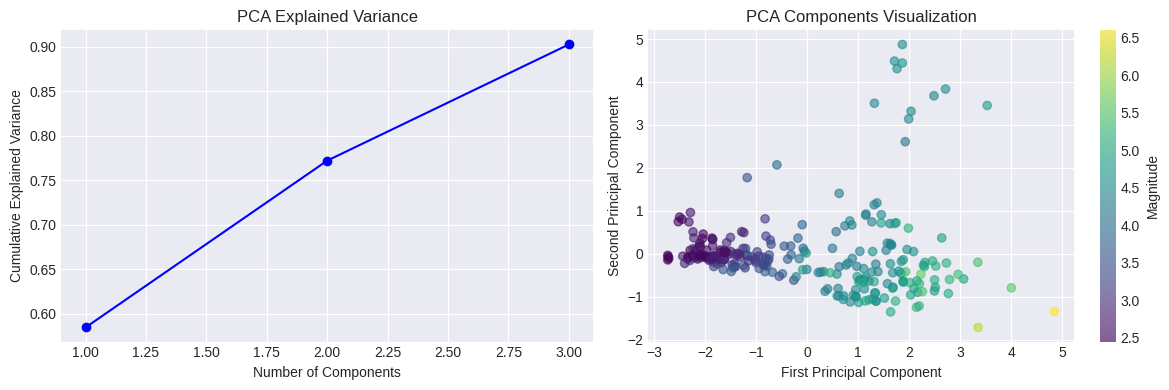


Dimensionality Reduction Complete!
------------------------------
Original features: 5
Reduced features: 3

Sample of Reduced Data:
        PC1       PC2       PC3
0 -1.705110  0.030258 -0.690417
1 -2.099410 -0.032181 -0.311015
2  1.346675 -1.104969  0.700895
3 -2.083007 -0.088547  0.889629
4 -2.290469  0.959757  1.135625


In [8]:
# Chunk #6b: Predictive Modeling - Dimensionality Reduction

def perform_dimensionality_reduction(processed_df, feature_sets):
    """
    Perform PCA dimensionality reduction on earthquake data

    Parameters:
    processed_df (pandas DataFrame): Processed earthquake data
    feature_sets (dict): Dictionary containing feature sets for different models

    Returns:
    tuple: (X_reduced, pca_model, scaler)
    """
    print("\nPerforming Dimensionality Reduction:")
    print("-" * 30)

    # Get features for PCA
    X_pca = processed_df[feature_sets['pca_features']].copy()

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_pca)

    # Apply PCA
    pca = PCA(n_components=3)  # Reduce to 3 components
    X_reduced = pca.fit_transform(X_scaled)

    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Print PCA results
    print("PCA Results:")
    for i, variance in enumerate(pca.explained_variance_ratio_):
        print(f"Component {i+1}: {variance:.4f} explained variance")
    print(f"Cumulative explained variance: {cumulative_variance[-1]:.4f}")

    # Create DataFrame with reduced features
    reduced_df = pd.DataFrame(
        X_reduced,
        columns=['PC1', 'PC2', 'PC3'],
        index=processed_df.index
    )

    # Visualize PCA results
    plt.figure(figsize=(12, 4))

    # Component variance plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 4), cumulative_variance, 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')

    # First two components scatter plot
    plt.subplot(1, 2, 2)
    scatter = plt.scatter(
        reduced_df['PC1'],
        reduced_df['PC2'],
        c=processed_df['magnitude'],
        cmap='viridis',
        alpha=0.6
    )
    plt.colorbar(scatter, label='Magnitude')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('PCA Components Visualization')

    plt.tight_layout()
    plt.show()

    return X_reduced, pca, scaler

# Test the dimensionality reduction
if __name__ == "__main__":
    # Fetch and prepare the data
    df = fetch_earthquake_data(timeframe='week', min_magnitude=2.5)

    if df is not None:
        # Prepare data
        processed_df, feature_sets = prepare_data_for_modeling(df)

        # Perform dimensionality reduction
        X_reduced, pca, scaler = perform_dimensionality_reduction(processed_df, feature_sets)

        # Print confirmation
        print("\nDimensionality Reduction Complete!")
        print("-" * 30)
        print(f"Original features: {len(feature_sets['pca_features'])}")
        print(f"Reduced features: {X_reduced.shape[1]}")

        # Display sample of reduced data
        print("\nSample of Reduced Data:")
        print(pd.DataFrame(X_reduced, columns=['PC1', 'PC2', 'PC3']).head())

## 6c. Predictive Modeling - Classification Model

Fetching data from https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson

Data Collection Summary:
------------------------------
Total earthquakes collected: 260
Date range: 2024-11-12 14:31:59.248000 to 2024-11-19 13:36:19.190000
Magnitude range: 2.5 to 6.6
------------------------------

Preparing Data for Modeling:
------------------------------
Data Preparation Summary:
Total samples: 260
Features created: hour, day_of_week, risk_category
Missing values handled for 7 features

Performing Dimensionality Reduction:
------------------------------
PCA Results:
Component 1: 0.5847 explained variance
Component 2: 0.1875 explained variance
Component 3: 0.1306 explained variance
Cumulative explained variance: 0.9027


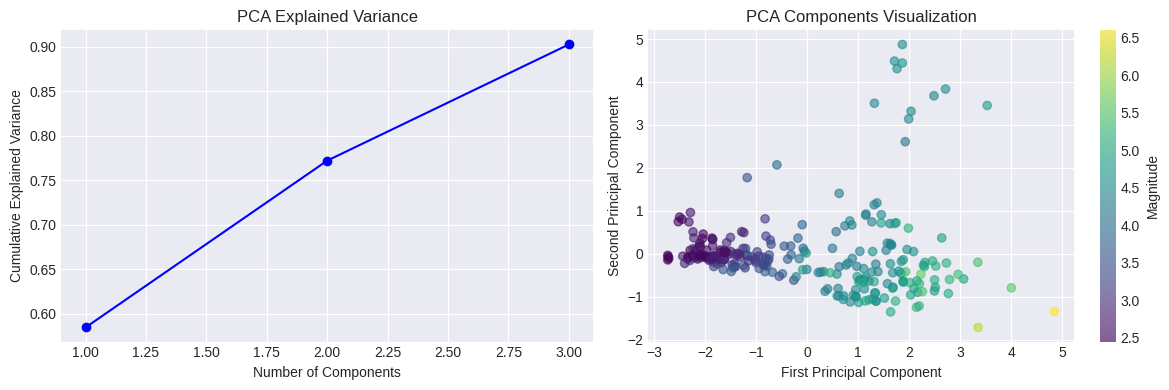


Training Risk Classification Model:
------------------------------


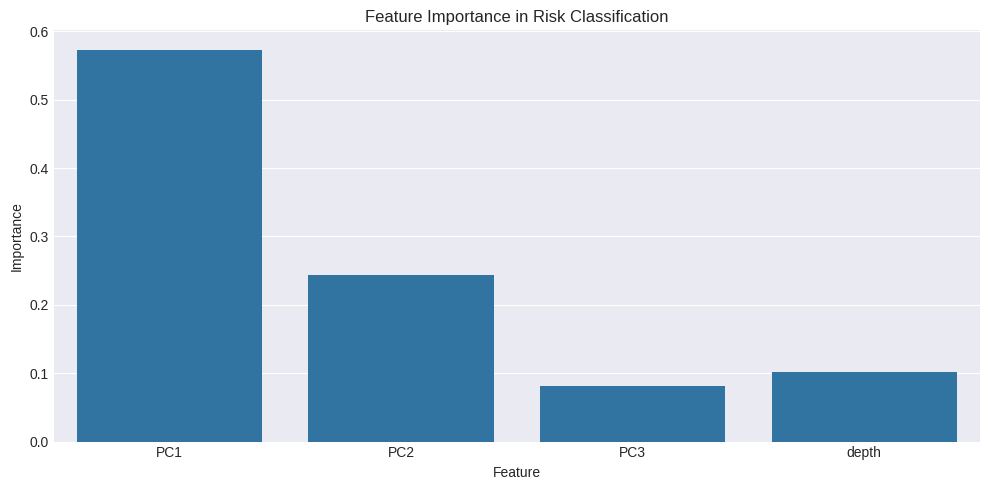


Classification Report:
              precision    recall  f1-score   support

        High       0.72      0.87      0.79        15
         Low       0.95      0.95      0.95        19
      Medium       0.80      0.67      0.73        18

    accuracy                           0.83        52
   macro avg       0.82      0.83      0.82        52
weighted avg       0.83      0.83      0.83        52


Feature Importance:
PC1: 0.5728
PC2: 0.2435
PC3: 0.0818
depth: 0.1019

Classification Model Training Complete!
------------------------------


In [9]:
# Chunk #6c: Predictive Modeling - Classification Model

def train_risk_classifier(processed_df, X_reduced):
    """
    Train and evaluate Random Forest Classifier for earthquake risk classification

    Parameters:
    processed_df (pandas DataFrame): Processed earthquake data
    X_reduced (numpy array): PCA-reduced features

    Returns:
    tuple: (trained_classifier, classification_metrics)
    """
    print("\nTraining Risk Classification Model:")
    print("-" * 30)

    # Prepare features and target
    X_class = np.column_stack([X_reduced, processed_df['depth']])
    y_class = processed_df['risk_category']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_class, y_class, test_size=0.2, random_state=42
    )

    # Train classifier
    clf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    )
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_test)

    # Calculate metrics
    classification_metrics = {
        'report': classification_report(y_test, y_pred),
        'feature_importance': dict(zip(
            ['PC1', 'PC2', 'PC3', 'depth'],
            clf.feature_importances_
        ))
    }

    # Visualize feature importance
    plt.figure(figsize=(10, 5))
    importance_df = pd.DataFrame({
        'Feature': ['PC1', 'PC2', 'PC3', 'depth'],
        'Importance': clf.feature_importances_
    })
    sns.barplot(data=importance_df, x='Feature', y='Importance')
    plt.title('Feature Importance in Risk Classification')
    plt.tight_layout()
    plt.show()

    # Print results
    print("\nClassification Report:")
    print(classification_metrics['report'])
    print("\nFeature Importance:")
    for feature, importance in classification_metrics['feature_importance'].items():
        print(f"{feature}: {importance:.4f}")

    return clf, classification_metrics

# Test the classification model
if __name__ == "__main__":
    # Fetch and prepare the data
    df = fetch_earthquake_data(timeframe='week', min_magnitude=2.5)

    if df is not None:
        # Prepare data
        processed_df, feature_sets = prepare_data_for_modeling(df)

        # Perform dimensionality reduction
        X_reduced, pca, scaler = perform_dimensionality_reduction(processed_df, feature_sets)

        # Train classifier
        clf, metrics = train_risk_classifier(processed_df, X_reduced)

        # Print confirmation
        print("\nClassification Model Training Complete!")
        print("-" * 30)

## 6c. Deep Learning Classification Model

Fetching data from https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson

Data Collection Summary:
------------------------------
Total earthquakes collected: 260
Date range: 2024-11-12 14:31:59.248000 to 2024-11-19 13:36:19.190000
Magnitude range: 2.5 to 6.6
------------------------------

Preparing Data for Modeling:
------------------------------
Data Preparation Summary:
Total samples: 260
Features created: hour, day_of_week, risk_category
Missing values handled for 7 features

Performing Dimensionality Reduction:
------------------------------
PCA Results:
Component 1: 0.5847 explained variance
Component 2: 0.1875 explained variance
Component 3: 0.1306 explained variance
Cumulative explained variance: 0.9027


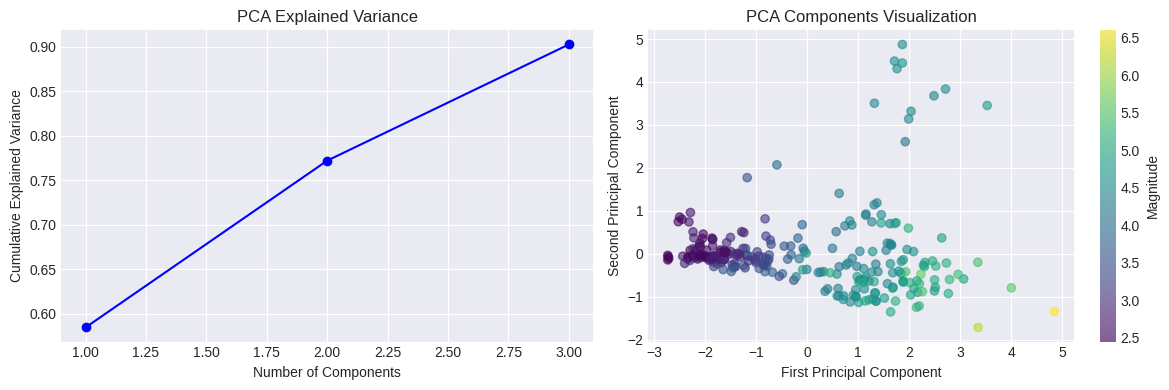


Training Risk Classification Model (MLP - Online Learning):
------------------------------

Classification Report:
              precision    recall  f1-score   support

        High       0.68      0.87      0.76        15
         Low       0.66      1.00      0.79        19
      Medium       0.50      0.11      0.18        18

    accuracy                           0.65        52
   macro avg       0.61      0.66      0.58        52
weighted avg       0.61      0.65      0.57        52

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
The best parameters: {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'solver': 'adam'}

Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.73      0.85        15
         Low       0.76      1.00      0.86        19
      Medium       0.75      0.67      0.71        18

    accuracy               

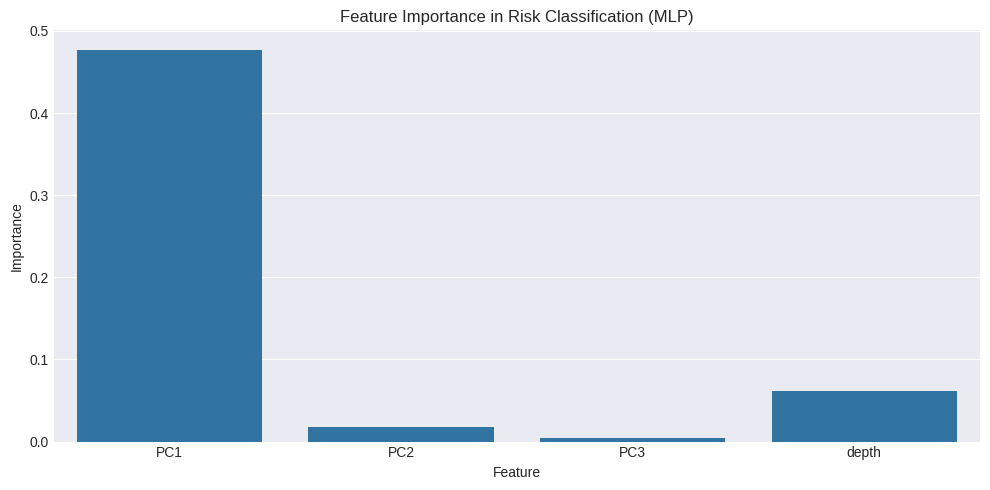

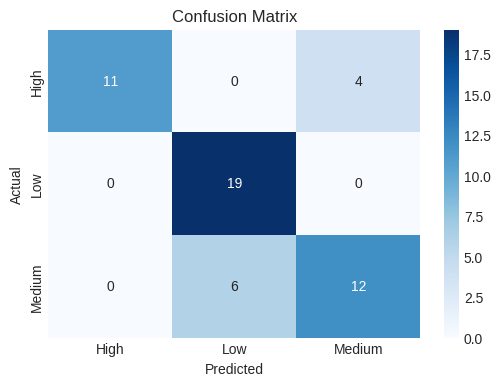


Classification Model Training Complete!
------------------------------


In [10]:
# Chunk #6c: Deep Learning Classification Model
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score

def get_feature_importance_mlp(clf, X_test, y_test, y_pred, feature_index, num_permutations=10):
    """
    Calculate feature importance by permuting a specific feature and measuring accuracy drop.

    Parameters:
    clf: Trained classifier (MLPClassifier)
    X_test: Features of the test set
    y_test: Actual target values
    y_pred: Predicted target values
    feature_index: The index of the feature to permute
    num_permutations: The number of permutations to perform (default is 10)

    Returns:
    importance_score: The computed importance of the given feature
    """

    # Calculate baseline accuracy
    baseline_accuracy = accuracy_score(y_test, y_pred)

    # Initialize total importance reduction
    total_reduction = 0.0

    for _ in range(num_permutations):
        # Permute the selected feature column
        X_test_permuted = X_test.copy()
        permuted_indices = np.random.permutation(X_test.shape[0])
        X_test_permuted[:, feature_index] = X_test[permuted_indices, feature_index]

        # Calculate accuracy with the permuted feature
        y_pred_permuted = clf.predict(X_test_permuted)
        permuted_accuracy = accuracy_score(y_test, y_pred_permuted)

        # Accumulate the accuracy reduction
        total_reduction += (baseline_accuracy - permuted_accuracy)

    # Average reduction over the number of permutations
    importance_score = total_reduction / num_permutations

    return importance_score

def train_risk_classifier_mlp(processed_df, X_reduced):
    """
    Train and evaluate MLP for earthquake risk classification with online learning.

    Parameters:
    processed_df (pandas DataFrame): Processed earthquake data
    X_reduced (numpy array): PCA-reduced features

    Returns:
    tuple: (trained_classifier, classification_metrics)
    """
    print("\nTraining Risk Classification Model (MLP - Online Learning):")
    print("-" * 30)

    # Prepare features and target
    X_class = np.column_stack([X_reduced, processed_df['depth']])
    y_class = processed_df['risk_category']

    # Split data (initial training data)
    X_train, X_test, y_train, y_test = train_test_split(
        X_class, y_class, test_size=0.2, random_state=42
    )

    # Initialize MLP with learning parameters
    clf = MLPClassifier(
        hidden_layer_sizes=(128,64,64),  # Hidden layers with 128, 64, 64 neurons
        activation='relu',         # ReLU activation function
        solver='adam',             # Optimizer
        learning_rate='adaptive',  # Adjust learning rate dynamically
        learning_rate_init=0.001,  # Initial learning rate
        alpha=0.0001,              # Regularization strength (L2 penalty)
        max_iter=500,              # Max iterations
        random_state=42,           # Random seed for reproducibility
        warm_start=True            # Partial fitting for incremental learning
    )

    # Train classifier on initial batch
    clf.fit(X_train, y_train)

    # Make initial predictions and calculate initial metrics
    y_pred = clf.predict(X_test)

    # Calculate metrics
    classification_metrics = {
        'report': classification_report(y_test, y_pred)
    }

    # Print classification report for the initial batch
    print("\nClassification Report:")
    print(classification_metrics['report'])

    # Initialize MLP with learning parameters
    mlpc = MLPClassifier(
        max_iter=500,              # Max iterations
        random_state=42,           # Random seed for reproducibility
        warm_start=True            # Partial fitting for incremental learning
    )

    mlpc_params = {
              "alpha": [0.1, 0.01, 0.0001],
              "hidden_layer_sizes": [(128,64,64),
                                     (128,64),
                                     (128,64,32)],
              "learning_rate_init": [0.1, 0.01, 0.0001],
              "learning_rate" : ["constant","adaptive","invscaling"],
              "solver" : ["lbfgs","adam","sgd"],
              "activation": ["relu","logistic"]
    }

    # Model CV process
    mlpc_cv_model = GridSearchCV(mlpc, mlpc_params,
                            cv = 5, # To make a 5-fold CV
                            n_jobs = -1, # Number of jobs to be run in parallel (-1: means to use all processors)
                            verbose = 2) # Controls the level of detail: higher means more messages gets value as integer.

    mlpc_cv_model.fit(X_train, y_train)

    # The best parameter obtained as a result of CV process
    print("The best parameters: " + str(mlpc_cv_model.best_params_))

    # Model Tuning
    # Setting the Final Model with the best parameter
    mlpc_tuned = mlpc_cv_model.best_estimator_

    # Fitting Final Model
    mlpc_tuned.fit(X_train, y_train)

    # Make initial predictions and calculate initial metrics
    y_pred = mlpc_tuned.predict(X_test)

    # Calculate metrics
    classification_metrics = {
        'report': classification_report(y_test, y_pred)
    }

    # Print classification report for the initial batch
    print("\nClassification Report:")
    print(classification_metrics['report'])

    # K fold accuracy
    kf = KFold(shuffle=True, n_splits=5) # To make a 5-fold CV
    cv_results_kfold = cross_val_score(mlpc_tuned, X_test, y_test, cv=kf, scoring='accuracy')
    print("K-fold Cross Validation accuracy Results: ",cv_results_kfold)
    print("K-fold Cross Validation accuracy Results Mean: ",cv_results_kfold.mean())

    # Compute feature importance by permuting features
    feature_importances = []
    feature_names = ['PC1', 'PC2', 'PC3', 'depth']  # Feature names
    for j in range(X_test.shape[1]):  # Loop over each feature
        importance = get_feature_importance_mlp(mlpc_tuned, X_test, y_test, y_pred, feature_index=j, num_permutations=10)
        feature_importances.append(importance)

    # Visualize feature importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    plt.figure(figsize=(10, 5))
    sns.barplot(data=importance_df, x='Feature', y='Importance')
    plt.title('Feature Importance in Risk Classification (MLP)')
    plt.tight_layout()
    plt.show()

    # Plot the confusion matrix as a heatmap
    cm = confusion_matrix(y_test, y_pred)
    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['High', 'Low', 'Medium'], yticklabels=['High', 'Low', 'Medium'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    '''
    # Simulate real-time data stream and update model
    print("\nSimulating Real-Time Data Stream...")

    # For the purpose of demonstration, we use the same processed data in batches (in practice, this comes from real-time data)
    for i in range(len(X_train), len(X_class), 10):  # Update in batches of 10 (you can adjust)
        batch_data = X_class[i:i+10]
        batch_target = y_class[i:i+10]

        # Update model incrementally using partial_fit
        clf.partial_fit(batch_data, batch_target, classes=np.unique(y_class))

        # Predict and evaluate after each batch
        y_pred_batch = clf.predict(X_test)
        batch_report = classification_report(y_test, y_pred_batch)

        # Print updated metrics
        print(f"\nBatch {i // 10} - Real-time Classification Report:")
        print(batch_report)
    '''
    return clf, classification_metrics

# Test the classification model
if __name__ == "__main__":
    # Fetch and prepare the data
    df = fetch_earthquake_data(timeframe='week', min_magnitude=2.5)

    if df is not None:
        # Prepare data
        processed_df, feature_sets = prepare_data_for_modeling(df)

        # Perform dimensionality reduction
        X_reduced, pca, scaler = perform_dimensionality_reduction(processed_df, feature_sets)

        # Train classifier
        clf, metrics = train_risk_classifier_mlp(processed_df, X_reduced)

        # Print confirmation
        print("\nClassification Model Training Complete!")
        print("-" * 30)

## 6d.Predictive Modeling - Regression Model

Fetching data from https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson

Data Collection Summary:
------------------------------
Total earthquakes collected: 249
Date range: 2024-11-09 01:12:44.321000 to 2024-11-15 23:29:29.760000
Magnitude range: 2.5 to 6.8
------------------------------

Preparing Data for Modeling:
------------------------------
Data Preparation Summary:
Total samples: 249
Features created: hour, day_of_week, risk_category
Missing values handled for 7 features

Training Magnitude Regression Model:
------------------------------


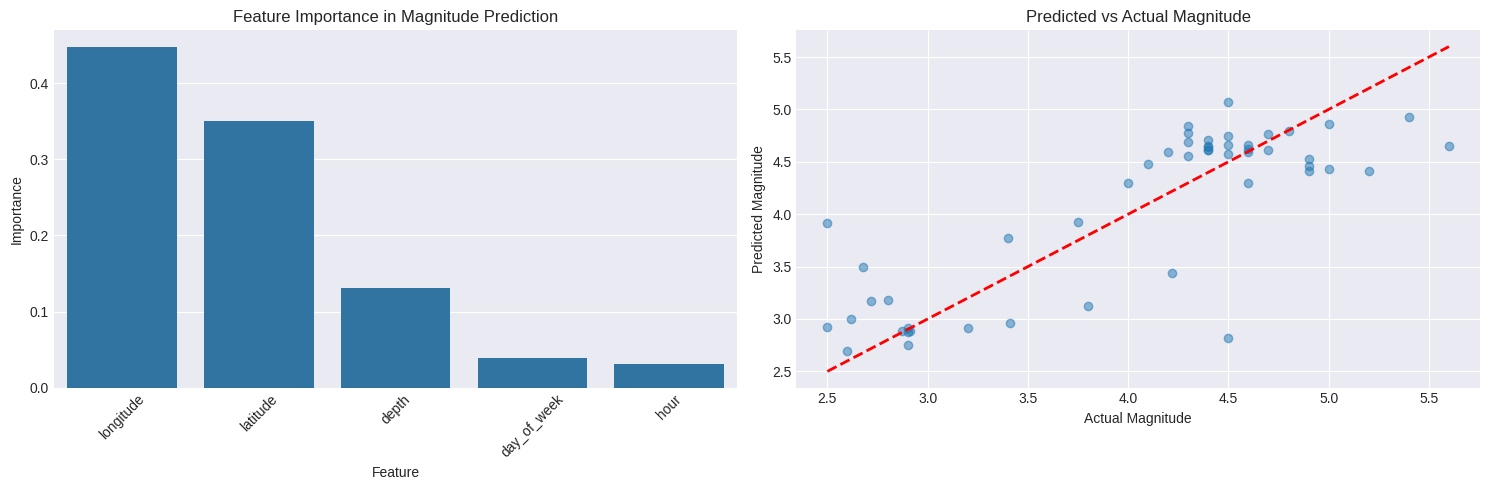


Regression Metrics:
Mean Squared Error: 0.2468
Root Mean Squared Error: 0.4968
R² Score: 0.6628

Feature Importance:
depth: 0.1314
latitude: 0.3508
longitude: 0.4472
hour: 0.0313
day_of_week: 0.0393

Regression Model Training Complete!
------------------------------


In [ ]:
# Chunk #6d: Predictive Modeling - Regression Model

def train_magnitude_regressor(processed_df, feature_sets):
    """
    Train and evaluate Random Forest Regressor for earthquake magnitude prediction

    Parameters:
    processed_df (pandas DataFrame): Processed earthquake data
    feature_sets (dict): Dictionary containing feature sets for different models

    Returns:
    tuple: (trained_regressor, regression_metrics)
    """
    print("\nTraining Magnitude Regression Model:")
    print("-" * 30)

    # Prepare features and target
    X_reg = processed_df[feature_sets['regression_features']]
    y_reg = processed_df['magnitude']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_reg, y_reg, test_size=0.2, random_state=42
    )

    # Train regressor
    reg = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    )
    reg.fit(X_train, y_train)

    # Make predictions
    y_pred = reg.predict(X_test)

    # Calculate metrics
    regression_metrics = {
        'mse': mean_squared_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'r2': r2_score(y_test, y_pred),
        'feature_importance': dict(zip(
            feature_sets['regression_features'],
            reg.feature_importances_
        ))
    }

    # Visualizations
    plt.figure(figsize=(15, 5))

    # Feature importance plot
    plt.subplot(1, 2, 1)
    importance_df = pd.DataFrame({
        'Feature': feature_sets['regression_features'],
        'Importance': reg.feature_importances_
    }).sort_values('Importance', ascending=False)
    sns.barplot(data=importance_df, x='Feature', y='Importance')
    plt.title('Feature Importance in Magnitude Prediction')
    plt.xticks(rotation=45)

    # Predicted vs Actual plot
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Magnitude')
    plt.ylabel('Predicted Magnitude')
    plt.title('Predicted vs Actual Magnitude')

    plt.tight_layout()
    plt.show()

    # Print results
    print("\nRegression Metrics:")
    print(f"Mean Squared Error: {regression_metrics['mse']:.4f}")
    print(f"Root Mean Squared Error: {regression_metrics['rmse']:.4f}")
    print(f"R² Score: {regression_metrics['r2']:.4f}")

    print("\nFeature Importance:")
    for feature, importance in regression_metrics['feature_importance'].items():
        print(f"{feature}: {importance:.4f}")

    return reg, regression_metrics

# Test the regression model
if __name__ == "__main__":
    # Fetch and prepare the data
    df = fetch_earthquake_data(timeframe='week', min_magnitude=2.5)

    if df is not None:
        # Prepare data
        processed_df, feature_sets = prepare_data_for_modeling(df)

        # Train regressor
        reg, metrics = train_magnitude_regressor(processed_df, feature_sets)

        # Print confirmation
        print("\nRegression Model Training Complete!")
        print("-" * 30)

# 6.LSTM Time Series Model

### 6e-1. Feature Engineering

In [ ]:
# Chunk #6e-1: Predictive Modeling - Feature Engineering for LSTM

def engineer_lstm_features(processed_df):
    """
    Create engineered features for LSTM model

    Parameters:
    processed_df (pandas DataFrame): Processed earthquake data

    Returns:
    pandas DataFrame: Data with engineered features
    """
    print("\nEngineering Features for LSTM:")
    print("-" * 30)

    # Select base features
    sequence_features = [
        'magnitude', 'depth', 'sig', 'latitude', 'longitude',
        'hour', 'day_of_week'
    ]

    # Create new dataframe with selected features
    sequence_data = processed_df[sequence_features].copy()

    # Add rolling statistics
    sequence_data['rolling_mean_mag'] = processed_df['magnitude'].rolling(window=5).mean()
    sequence_data['rolling_std_mag'] = processed_df['magnitude'].rolling(window=5).std()

    # Handle any missing values from rolling calculations
    sequence_data.fillna(method='bfill', inplace=True)

    # Print summary
    print("Features created:")
    for col in sequence_data.columns:
        print(f"- {col}: {sequence_data[col].dtype}")
    print(f"\nTotal features: {len(sequence_data.columns)}")
    print(f"Data shape: {sequence_data.shape}")

    return sequence_data

# Test the feature engineering
if __name__ == "__main__":
    # Fetch and prepare the data
    df = fetch_earthquake_data(timeframe='week', min_magnitude=2.5)

    if df is not None:
        # Prepare data
        processed_df, feature_sets = prepare_data_for_modeling(df)

        # Engineer features
        sequence_data = engineer_lstm_features(processed_df)

        # Print confirmation
        print("\nFeature Engineering Complete!")
        print("-" * 30)
        print("\nSample of engineered data:")
        print(sequence_data.head())

Fetching data from https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson

Data Collection Summary:
------------------------------
Total earthquakes collected: 249
Date range: 2024-11-09 01:12:44.321000 to 2024-11-15 23:29:29.760000
Magnitude range: 2.5 to 6.8
------------------------------

Preparing Data for Modeling:
------------------------------
Data Preparation Summary:
Total samples: 249
Features created: hour, day_of_week, risk_category
Missing values handled for 7 features

Engineering Features for LSTM:
------------------------------
Features created:
- magnitude: float64
- depth: float64
- sig: int64
- latitude: float64
- longitude: float64
- hour: int32
- day_of_week: int32
- rolling_mean_mag: float64
- rolling_std_mag: float64

Total features: 9
Data shape: (249, 9)

Feature Engineering Complete!
------------------------------

Sample of engineered data:
   magnitude    depth  sig   latitude   longitude  hour  day_of_week  \
0       3.92   69.000  236  

### 6e-2.Sequence Preparation

In [ ]:
# Chunk #6e-2: Predictive Modeling - Sequence Preparation

def prepare_lstm_sequences(sequence_data, processed_df, sequence_length=10):
    """
    Prepare sequences for LSTM model

    Parameters:
    sequence_data (pandas DataFrame): Data with engineered features
    processed_df (pandas DataFrame): Original processed data
    sequence_length (int): Length of sequences

    Returns:
    tuple: (X_train, X_test, y_train, y_test, scaler)
    """
    print("\nPreparing Sequences for LSTM:")
    print("-" * 30)

    # Normalize the data
    scaler = StandardScaler()
    normalized_data = pd.DataFrame(
        scaler.fit_transform(sequence_data),
        columns=sequence_data.columns
    )

    # Create sequences
    sequences = []
    targets = []

    for i in range(len(normalized_data) - sequence_length):
        sequences.append(normalized_data.iloc[i:i+sequence_length].values)
        targets.append(processed_df['magnitude'].iloc[i+sequence_length])

    X = np.array(sequences)
    y = np.array(targets)

    # Split the data
    train_size = int(len(X) * 0.85)
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]

    # Print summary
    print(f"Sequence length: {sequence_length}")
    print(f"Total sequences: {len(X)}")
    print(f"Training sequences: {len(X_train)}")
    print(f"Testing sequences: {len(X_test)}")
    print(f"\nSequence shape: {X_train.shape}")

    return X_train, X_test, y_train, y_test, scaler

# Test the sequence preparation
if __name__ == "__main__":
    # Fetch and prepare the data
    df = fetch_earthquake_data(timeframe='week', min_magnitude=2.5)

    if df is not None:
        # Prepare data
        processed_df, feature_sets = prepare_data_for_modeling(df)

        # Engineer features
        sequence_data = engineer_lstm_features(processed_df)

        # Prepare sequences
        X_train, X_test, y_train, y_test, scaler = prepare_lstm_sequences(
            sequence_data, processed_df
        )

        # Print confirmation
        print("\nSequence Preparation Complete!")
        print("-" * 30)

Fetching data from https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson

Data Collection Summary:
------------------------------
Total earthquakes collected: 249
Date range: 2024-11-09 01:12:44.321000 to 2024-11-15 23:29:29.760000
Magnitude range: 2.5 to 6.8
------------------------------

Preparing Data for Modeling:
------------------------------
Data Preparation Summary:
Total samples: 249
Features created: hour, day_of_week, risk_category
Missing values handled for 7 features

Engineering Features for LSTM:
------------------------------
Features created:
- magnitude: float64
- depth: float64
- sig: int64
- latitude: float64
- longitude: float64
- hour: int32
- day_of_week: int32
- rolling_mean_mag: float64
- rolling_std_mag: float64

Total features: 9
Data shape: (249, 9)

Preparing Sequences for LSTM:
------------------------------
Sequence length: 10
Total sequences: 239
Training sequences: 203
Testing sequences: 36

Sequence shape: (203, 10, 9)

Sequence P

### 6e-3.LSTM Model Training

Fetching data from https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson

Data Collection Summary:
------------------------------
Total earthquakes collected: 252
Date range: 2024-11-08 02:34:42.740000 to 2024-11-15 00:11:58.311000
Magnitude range: 2.5 to 6.8
------------------------------

Preparing Data for Modeling:
------------------------------
Data Preparation Summary:
Total samples: 252
Features created: hour, day_of_week, risk_category
Missing values handled for 7 features

Engineering Features for LSTM:
------------------------------
Features created:
- magnitude: float64
- depth: float64
- sig: int64
- latitude: float64
- longitude: float64
- hour: int32
- day_of_week: int32
- rolling_mean_mag: float64
- rolling_std_mag: float64

Total features: 9
Data shape: (252, 9)

Preparing Sequences for LSTM:
------------------------------
Sequence length: 10
Total sequences: 242
Training sequences: 205
Testing sequences: 37

Sequence shape: (205, 10, 9)

Training L

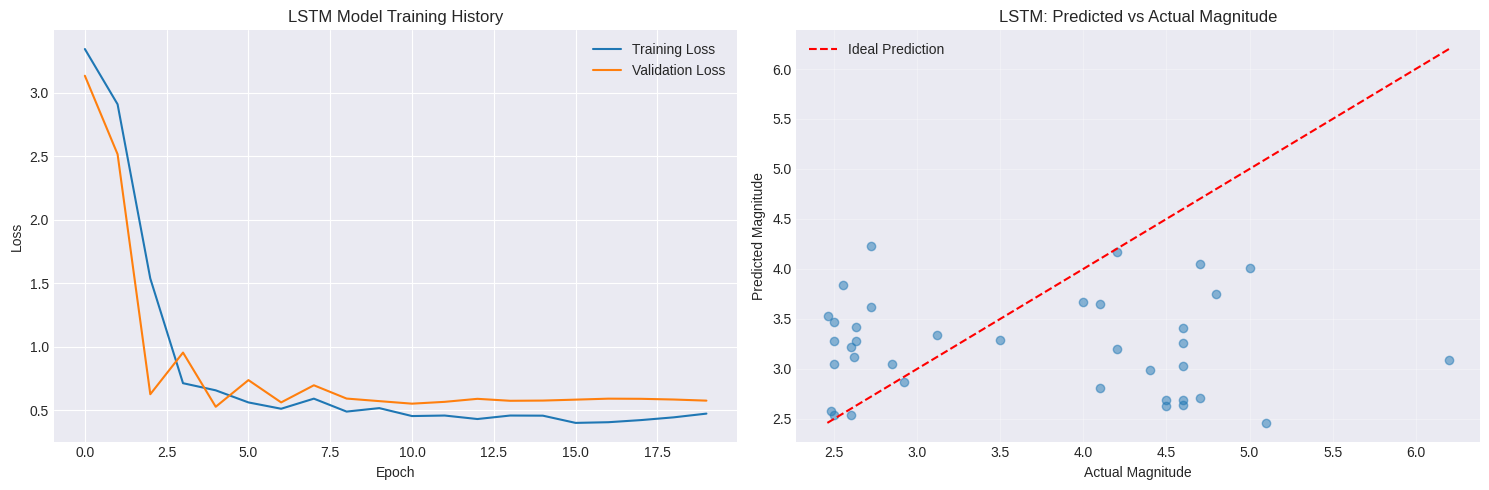


Final Model Metrics:
Mean Squared Error: 1.5579
Root Mean Squared Error: 1.2481
Mean Absolute Error: 1.0031

LSTM Model Training Complete!
------------------------------


In [ ]:
# Chunk #6e-3: Predictive Modeling - Fixed LSTM Model Training

def create_lstm_model(input_shape):
    """
    Create LSTM model architecture
    """
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(10, activation='relu'),
        Dense(1, activation='relu')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer,
                 loss=tf.keras.losses.Huber(delta=1.0),
                 metrics=['mae'])

    return model

def plot_training_results(history, y_test, y_pred):
    """
    Plot training history and predictions
    """
    plt.figure(figsize=(15, 5))

    # Training history plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Prediction plot
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred, alpha=0.5)

    # Plot ideal prediction line
    min_val = min(min(y_test), min(y_pred))
    max_val = max(max(y_test), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Prediction')

    plt.xlabel('Actual Magnitude')
    plt.ylabel('Predicted Magnitude')
    plt.title('LSTM: Predicted vs Actual Magnitude')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def train_lstm_model(X_train, X_test, y_train, y_test):
    """
    Train and evaluate LSTM model
    """
    print("\nTraining LSTM Model:")
    print("-" * 30)

    # Create model
    print("Creating model architecture...")
    model = create_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001
    )

    # Train model
    print("\nStarting model training...")
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=16,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Evaluate model
    print("\nEvaluating model performance...")
    y_pred = model.predict(X_test, verbose=0).flatten()  # Ensure 1D array

    metrics = {
        'mse': mean_squared_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': np.mean(np.abs(y_test - y_pred))
    }

    # Plot results
    plot_training_results(history, y_test, y_pred)

    # Print metrics
    print("\nFinal Model Metrics:")
    print(f"Mean Squared Error: {metrics['mse']:.4f}")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f}")

    return model, history, metrics

# Test the LSTM model training
if __name__ == "__main__":
    # Fetch and prepare the data
    df = fetch_earthquake_data(timeframe='week', min_magnitude=2.5)

    if df is not None:
        # Prepare data
        processed_df, feature_sets = prepare_data_for_modeling(df)

        print

        # Engineer features
        sequence_data = engineer_lstm_features(processed_df)

        # Prepare sequences
        X_train, X_test, y_train, y_test, scaler = prepare_lstm_sequences(
            sequence_data, processed_df
        )

        # Train model
        model, history, metrics = train_lstm_model(X_train, X_test, y_train, y_test)

        # Print confirmation
        print("\nLSTM Model Training Complete!")
        print("-" * 30)

### 6e-4.LSTM Model Implementation

Fetching data from https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson

Data Collection Summary:
------------------------------
Total earthquakes collected: 252
Date range: 2024-11-08 02:34:42.740000 to 2024-11-15 00:11:58.311000
Magnitude range: 2.5 to 6.8
------------------------------

Preparing Data for Modeling:
------------------------------
Data Preparation Summary:
Total samples: 252
Features created: hour, day_of_week, risk_category
Missing values handled for 7 features

Engineering Features for LSTM:
------------------------------
Features created:
- magnitude: float64
- depth: float64
- sig: int64
- latitude: float64
- longitude: float64
- hour: int32
- day_of_week: int32
- rolling_mean_mag: float64
- rolling_std_mag: float64

Total features: 9
Data shape: (252, 9)

Preparing Sequences for LSTM:
------------------------------
Sequence length: 10
Total sequences: 242
Training sequences: 205
Testing sequences: 37

Sequence shape: (205, 10, 9)

Training E

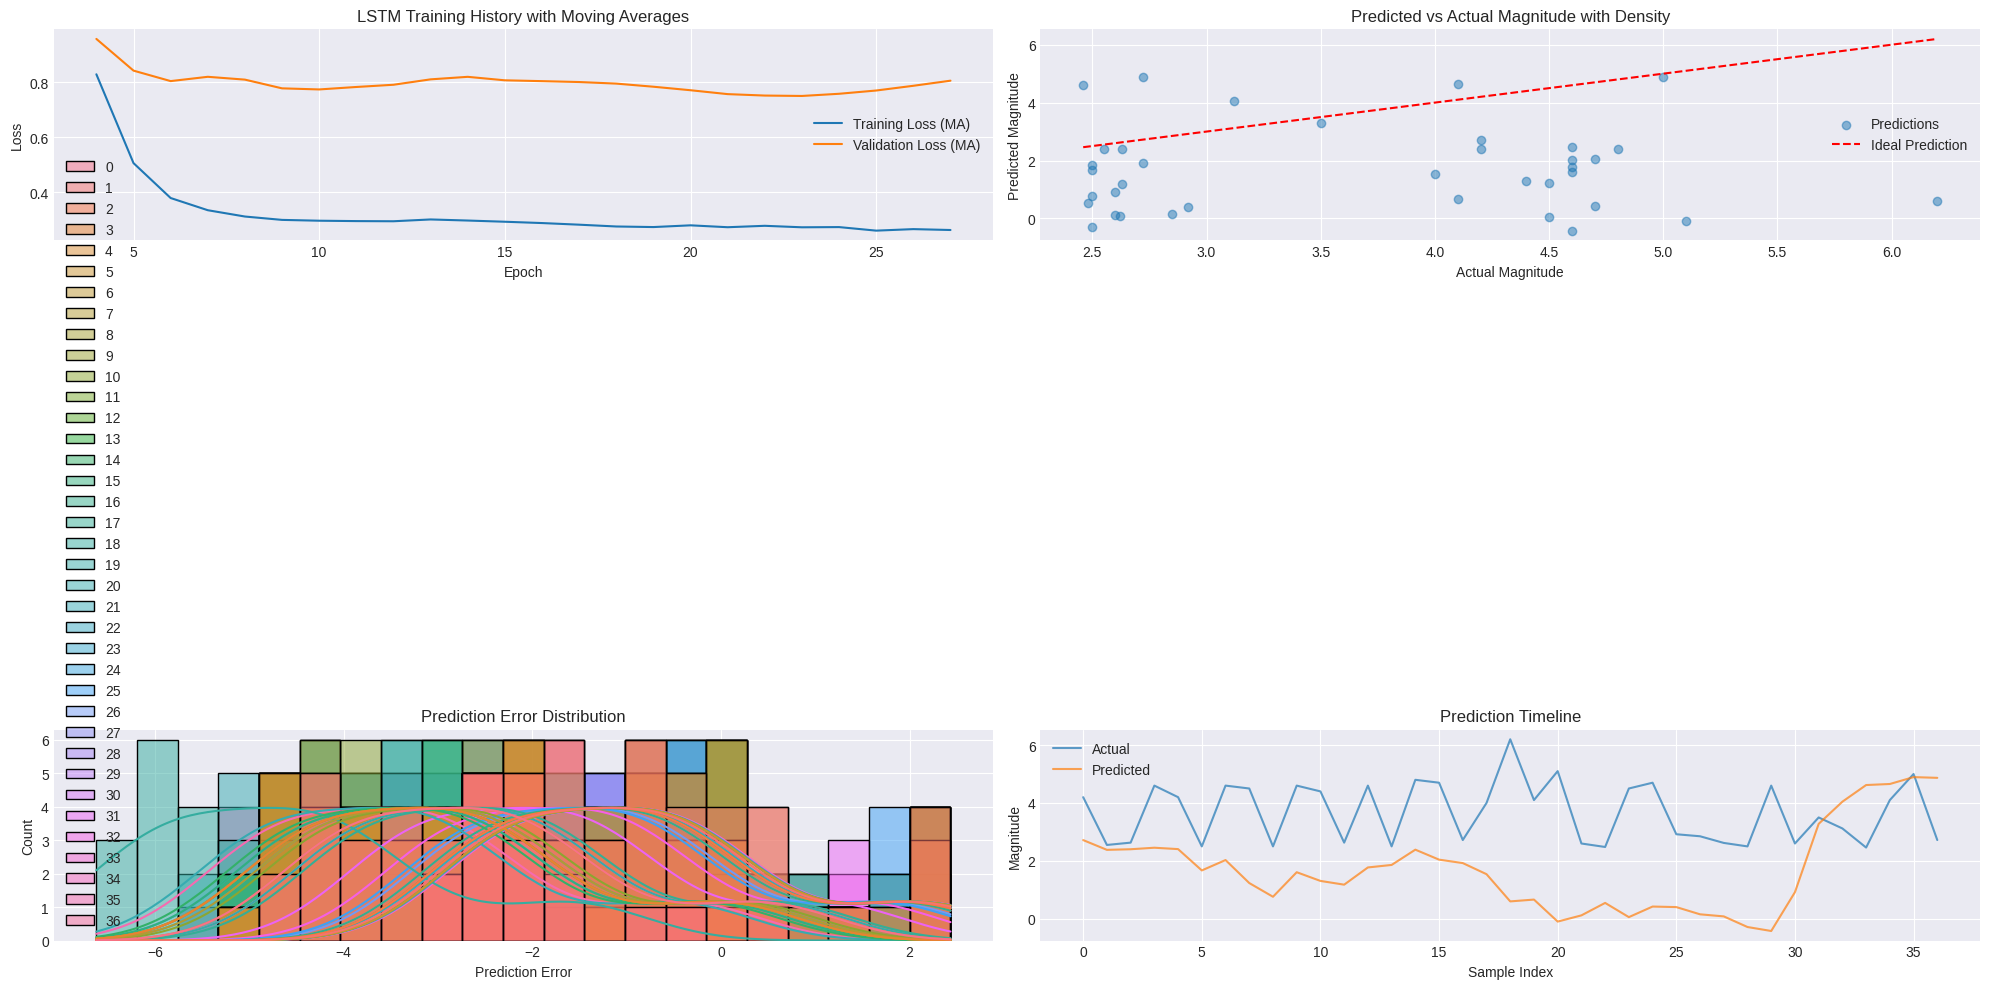


Detailed Model Metrics:
------------------------------
Mean Squared Error: 7.1387
Root Mean Squared Error: 2.6718
Mean Absolute Error: 2.2669

Prediction Analysis:
------------------------------
Predictions within 0.5 magnitude: 12.6%
Predictions within 1.0 magnitude: 23.4%

Enhanced LSTM Model Training Complete!
------------------------------
Final MSE: 7.1387
Final RMSE: 2.6718
Final MAE: 2.2669

Model saved as 'enhanced_lstm_model.keras'


In [ ]:
# Chunk #6e-4: Enhanced LSTM Model Implementation (Fixed)

def create_enhanced_lstm_model(input_shape, learning_rate=0.001):
    """
    Create an enhanced LSTM model with residual connections and additional regularization
    """
    # [Previous model creation code remains the same]
    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # First LSTM block with residual connection
    x = LSTM(128, return_sequences=True, activation='tanh')(inputs)
    x = Dropout(0.3)(x)
    x = LayerNormalization()(x)

    # Second LSTM block
    x = LSTM(64, return_sequences=False, activation='tanh')(x)
    x = Dropout(0.3)(x)
    x = LayerNormalization()(x)

    # Dense layers with residual connections
    dense1 = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(dense1)
    dense2 = Dense(16, activation='relu')(x)
    x = Concatenate()([dense1, dense2])  # Residual connection

    # Output layer
    outputs = Dense(1, activation='linear')(x)

    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile with Huber loss for robustness to outliers
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        clipnorm=1.0  # Gradient clipping
    )
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.Huber(delta=0.5),
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
    )

    return model

def train_enhanced_lstm_model(X_train, X_test, y_train, y_test, batch_size=32, epochs=150):
    """
    Train the enhanced LSTM model with advanced training techniques
    """
    print("\nTraining Enhanced LSTM Model:")
    print("-" * 30)

    # Create model
    model = create_enhanced_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    # Learning rate schedule
    lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )

    # Early stopping with restoration of best weights
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=25,
        restore_best_weights=True,
        verbose=1
    )

    # Model checkpoint - Updated to use .keras extension
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'best_lstm_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[lr_schedule, early_stopping, checkpoint],
        verbose=1
    )

    # Evaluate model
    y_pred = model.predict(X_test)

    metrics = {
        'mse': mean_squared_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': np.mean(np.abs(y_test - y_pred))
    }

    # Plot enhanced training results
    plot_enhanced_training_results(history, y_test, y_pred, metrics)

    return model, history, metrics

def plot_enhanced_training_results(history, y_test, y_pred, metrics):
    """
    Create enhanced visualization of model performance
    """
    plt.figure(figsize=(20, 10))

    # Training history with moving averages
    plt.subplot(2, 2, 1)
    plot_training_history_with_ma(history)

    # Prediction scatter with density
    plt.subplot(2, 2, 2)
    plot_prediction_scatter_with_density(y_test, y_pred)

    # Error distribution
    plt.subplot(2, 2, 3)
    plot_error_distribution(y_test, y_pred)

    # Prediction timeline
    plt.subplot(2, 2, 4)
    plot_prediction_timeline(y_test, y_pred)

    plt.tight_layout()
    plt.show()

    # Print detailed metrics
    print("\nDetailed Model Metrics:")
    print("-" * 30)
    print(f"Mean Squared Error: {metrics['mse']:.4f}")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f}")

    # Calculate additional metrics
    print("\nPrediction Analysis:")
    print("-" * 30)
    print(f"Predictions within 0.5 magnitude: {np.mean(np.abs(y_test - y_pred) < 0.5) * 100:.1f}%")
    print(f"Predictions within 1.0 magnitude: {np.mean(np.abs(y_test - y_pred) < 1.0) * 100:.1f}%")

# Helper functions for enhanced visualization
def plot_training_history_with_ma(history, window=5):
    """Plot training history with moving averages"""
    train_loss = pd.Series(history.history['loss']).rolling(window=window).mean()
    val_loss = pd.Series(history.history['val_loss']).rolling(window=window).mean()

    plt.plot(train_loss, label='Training Loss (MA)')
    plt.plot(val_loss, label='Validation Loss (MA)')
    plt.title('LSTM Training History with Moving Averages')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

def plot_prediction_scatter_with_density(y_true, y_pred):
    """Create scatter plot with density estimation"""
    plt.scatter(y_true, y_pred, alpha=0.5, label='Predictions')
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             'r--', label='Ideal Prediction')
    plt.xlabel('Actual Magnitude')
    plt.ylabel('Predicted Magnitude')
    plt.title('Predicted vs Actual Magnitude with Density')
    plt.legend()

def plot_error_distribution(y_true, y_pred):
    """Plot error distribution"""
    errors = y_pred - y_true
    sns.histplot(errors, kde=True)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')

def plot_prediction_timeline(y_true, y_pred):
    """Plot prediction timeline"""
    plt.plot(range(len(y_true)), y_true, label='Actual', alpha=0.7)
    plt.plot(range(len(y_pred)), y_pred, label='Predicted', alpha=0.7)
    plt.title('Prediction Timeline')
    plt.xlabel('Sample Index')
    plt.ylabel('Magnitude')
    plt.legend()

# Test the enhanced LSTM model
if __name__ == "__main__":
    # Fetch and prepare the data
    df = fetch_earthquake_data(timeframe='week', min_magnitude=2.5)

    if df is not None:
        # Prepare data
        processed_df, feature_sets = prepare_data_for_modeling(df)

        # Engineer features
        sequence_data = engineer_lstm_features(processed_df)

        # Prepare sequences
        X_train, X_test, y_train, y_test, scaler = prepare_lstm_sequences(
            sequence_data, processed_df
        )

        # Train enhanced model
        model, history, metrics = train_enhanced_lstm_model(
            X_train, X_test, y_train, y_test,
            batch_size=32,
            epochs=150
        )

        # Print final confirmation
        print("\nEnhanced LSTM Model Training Complete!")
        print("-" * 30)
        print(f"Final MSE: {metrics['mse']:.4f}")
        print(f"Final RMSE: {metrics['rmse']:.4f}")
        print(f"Final MAE: {metrics['mae']:.4f}")

        # Save the model - Updated to use .keras extension
        model.save('enhanced_lstm_model.keras')
        print("\nModel saved as 'enhanced_lstm_model.keras'")